In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython import display as ds
import matplotlib.image as mpimg
import cv2
import tensorflow as tf
import math


%matplotlib inline

/home/kvpcloud/.conda/envs/p3_gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
class Dataset:
    main = 'dataset/UCSD_Anomaly_Dataset.v1p2'
    train_images = np.load('{}/train.npy'.format(main))
    train_images_ = np.load('{}/train_.npy'.format(main))
    test_images = np.load('{}/test.npy'.format(main))
    test_images_ = np.load('{}/test_.npy'.format(main))

In [3]:
Dataset.train_images.shape

(200, 158, 238, 3)

In [4]:
Dataset.train_images[0]

array([[[0.36078431, 0.36078431, 0.36078431],
        [0.35686275, 0.35686275, 0.35686275],
        [0.31764706, 0.31764706, 0.31764706],
        ...,
        [0.16470588, 0.16470588, 0.16470588],
        [0.22352941, 0.22352941, 0.22352941],
        [0.29019608, 0.29019608, 0.29019608]],

       [[0.2745098 , 0.2745098 , 0.2745098 ],
        [0.2627451 , 0.2627451 , 0.2627451 ],
        [0.27843137, 0.27843137, 0.27843137],
        ...,
        [0.18823529, 0.18823529, 0.18823529],
        [0.19215686, 0.19215686, 0.19215686],
        [0.33333333, 0.33333333, 0.33333333]],

       [[0.30588235, 0.30588235, 0.30588235],
        [0.32941176, 0.32941176, 0.32941176],
        [0.3372549 , 0.3372549 , 0.3372549 ],
        ...,
        [0.24705882, 0.24705882, 0.24705882],
        [0.16862745, 0.16862745, 0.16862745],
        [0.28235294, 0.28235294, 0.28235294]],

       ...,

       [[0.41960784, 0.41960784, 0.41960784],
        [0.41960784, 0.41960784, 0.41960784],
        [0.43137255, 0

In [5]:
class Params:
    latent_feature_count = [10,10,3]
    epochs = 30
    

In [8]:
class Network:
    
    def __init__(self):
        self.graph = tf.Graph()
        with self.graph.as_default():
            with tf.name_scope('Input'):
                self.x = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X')
                self.x_ = tf.placeholder(tf.float32, shape=(None, 158, 238, 3), name='X_')
                
            self.cn = self.CreateNetwork(self.graph, self.x_)
            
    class CreateNetwork:
        def __init__(self, graph, x_):
            self.graph = graph
            self.x_ = x_
            
        def encoder(self, x):
            with self.graph.as_default():
                with tf.name_scope('Encoder'):
                    x = tf.layers.conv2d(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 1st Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_1', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1), )
                    print('After 1st Pooling', x.get_shape())

                    x = tf.layers.conv2d(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 2nd Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_2', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                    print('After 2nd Pooling', x.get_shape())

                    x = tf.layers.conv2d(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 3rd Conv', x.get_shape())
                    tf.summary.image('encoder_hidden_3', x[:,:,:,0:3],max_outputs=1)
                    
                    encoded = tf.layers.max_pooling2d(x, pool_size=(5,5), strides=(1,1))
                    print('After 3rd Pooling (Final Encoded)', x.get_shape())
                    tf.summary.image('encoder_hidden_final', encoded[:,:,:,0:3], max_outputs=1)
                    
                    with tf.name_scope('Latent'):
                    
                        latent = tf.layers.dense(tf.contrib.layers.flatten(encoded), #depricated
                                                  units=np.prod(Params.latent_feature_count), 
                                                  activation=tf.nn.relu)

                        print('Latent', latent.get_shape())
                        tf.summary.histogram('Latent', latent)

                
            return encoded, latent

        def decoder(self, encoded):
            with self.graph.as_default():
                with tf.name_scope('Decoder'):
                    #x = tf.reshape(encoded, [-1] + Params.latent_feature_count)
                    x = encoded
                    x = tf.layers.conv2d_transpose(x, filters=8, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 1st conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_1', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=16, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 2nd conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_2', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 3rd conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_3', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 4th conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_4', x[:,:,:,0:3],max_outputs=1)
                    
                    x = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.relu)
                    print('After 5th conv transpose', x.get_shape())
                    tf.summary.image('decoder_hidden_5', x[:,:,:,0:3],max_outputs=1)
                    
                    decoded = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5,5), strides=(1,1), activation=tf.nn.sigmoid)
                    print('After 6th conv transpose (final decoded)', decoded.get_shape())
                    tf.summary.image('decoder_hidden_decoded', decoded[:,:,:,0:3],max_outputs=1)

                with tf.name_scope('Loss'):
                    loss = tf.losses.mean_squared_error(labels=self.x_, predictions=decoded)
                    tf.summary.scalar("loss",loss)
                    
            return decoded, loss
        
        def lstm(self, latent):
            with self.graph.as_default():
                
                with tf.name_scope('LSTM') as lstm_scope:
                    x = tf.layers.dense(latent, units=np.prod(Params.latent_feature_count), activation=tf.nn.relu)

                    lstm = tf.contrib.rnn.BasicLSTMCell(512)
                    x_list = tf.split(x, 10, axis=0)

                    y_list, self.state = tf.nn.static_rnn(lstm, x_list, dtype = tf.float32)
                    
                    lstm_out = tf.stack(y_list[-1]) # we only need the last output
                    lstm_out = tf.layers.dense(lstm_out, np.prod(Params.latent_feature_count))
        
            return lstm_out
        
        def rbf(self, lstm_output):
            with self.graph.as_default():
                def get_cost(U, Z, Q): 
                    
                    cost = - (-U - tf.log(Z)) 
                    return tf.reduce_mean(cost)

                f = np.prod(Params.latent_feature_count)

                
                with tf.name_scope('RBF'):
                    X = lstm_output

                    P = tf.Variable(tf.truncated_normal([f]))
                    Q_ = tf.Variable(tf.truncated_normal([f])) 
                    global_step = tf.Variable(0, trainable=False)


                    Q = tf.diag(tf.square(Q_)) + tf.eye(f) 

                    X = tf.layers.dense(X, f)
                    X = tf.layers.dense(X, f)  

                    with tf.name_scope('Likelihood'):
                        
                        M = P - tf.matmul(X, Q)
                        
                        R = tf.matmul(M, Q)
                        
                        V = tf.matmul(R, tf.transpose(M))
                        
                        U = tf.reduce_sum(V, axis = 1, keepdims = True)
                        
                        Q_det = tf.matrix_determinant(Q)
                        
                        Z = tf.pow(tf.multiply(tf.pow(2*math.pi,f), Q_det), 1/2)
                        
                        Y_ = tf.divide(tf.exp(-U/2), Z)
                        
                        Y_ = tf.layers.dense(Y_, 1)
                        rbf_out = tf.layers.dense(Y_, 1)


                    with tf.name_scope('Loss'):
                        loss = get_cost(U, Z, Q) # 1- Y_[0]
                        tf.summary.scalar('loss', loss)

            return rbf_out, loss

        
    def initialize_spatial(self):
        # encoder, decoder, lstm, rbf = 
        
        with self.graph.as_default():
            with tf.name_scope('Spatial_Autoencoder'):
                encoded, latent = self.cn.encoder(self.x)
                print("Encoder: ", encoded.get_shape())
                tf.summary.histogram("Encoded", encoded)
                
                self.decoded, spatial_loss = self.cn.decoder(encoded)
                print("Decoder: ", self.decoded.get_shape())
                tf.summary.histogram("Decoded", self.decoded)
                tf.summary.scalar("Spatial_Loss", spatial_loss)
                
        return latent, spatial_loss
                
    def intialize_temportal(self, latent):
        with self.graph.as_default():
            with tf.name_scope('Temporal_Autoencoder'):
                lstm_out = self.cn.lstm(latent)
                print("LSTM: ", lstm_out.get_shape())
                tf.summary.histogram("LSTM", lstm_out)

                likelihood, likelihood_loss = self.cn.rbf(lstm_out)
                print("Likelihood: ", likelihood.get_shape())
                tf.summary.scalar("Temporal_Loss", likelihood_loss)
                
        return likelihood, likelihood_loss

    
    def get_optimizer_loss(self):
        
        with self.graph.as_default():
            
            latent, spatial_loss = self.initialize_spatial()
            #self.likelihood, likelihood_loss = self.initialize_temporal(latent)
            
            loss = spatial_loss #+ likelihood_loss
            tf.summary.scalar("Total_Loss", loss)
            
            with tf.name_scope('Optimization'):
                
                global_step = tf.Variable(0, trainable=False)
                starter_learning_rate = 0.001
                learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                                   int(Params.epochs / 3), 0.5, staircase=True)
                train = tf.train.GradientDescentOptimizer(learning_rate).minimize(spatial_loss, global_step=global_step)
                tf.summary.scalar("learning_rate",learning_rate)

            merged = tf.summary.merge_all()
        return train, merged, loss
        
        

In [9]:
loss_arr=[]
network = Network()
with tf.Session(graph=network.graph) as sess:

    
    optim_loss = network.get_optimizer_loss()
    
    train_writer = tf.summary.FileWriter('logdir/cae_train', sess.graph)
    
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(Params.epochs):
        _, merged, loss = sess.run(optim_loss, feed_dict={network.x:Dataset.train_images_,
                                                        network.x_: Dataset.train_images})
        
        if epoch % 50 == 0:
            print('epoch:', epoch, 'loss:', loss)
            train_writer.add_summary(merged, epoch)
            loss_arr.append(loss)
    
    #Dataset.latent = sess.run(network.latent,feed_dict={network.x:Dataset.train_images_,
    #                                        network.x_: Dataset.train_images})
    
    Dataset.likelihood, Dataset.reproduced_images = sess.run((network.likelihood, network.decoded),feed_dict={network.x:Dataset.test_images_,
                                            network.x_: Dataset.test_images})

After 1st Conv (?, 154, 234, 32)
After 1st Pooling (?, 150, 230, 32)
After 2nd Conv (?, 146, 226, 16)
After 2nd Pooling (?, 142, 222, 16)
After 3rd Conv (?, 138, 218, 8)
After 3rd Pooling (Final Encoded) (?, 138, 218, 8)
Latent (?, 300)
Encoder:  (?, 134, 214, 8)
After 1st conv transpose (?, 138, 218, 8)
After 2nd conv transpose (?, 142, 222, 16)
After 3rd conv transpose (?, 146, 226, 32)
After 4th conv transpose (?, 150, 230, 32)
After 5th conv transpose (?, 154, 234, 3)
After 6th conv transpose (final decoded) (?, 158, 238, 3)
Decoder:  (?, 158, 238, 3)
epoch: 0 loss: 0.05547515


AttributeError: 'Network' object has no attribute 'likelihood'

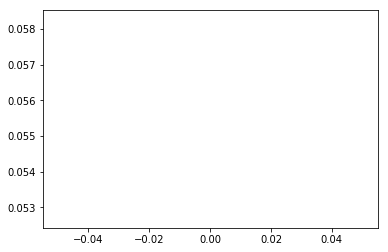

In [10]:
plt.plot(loss_arr)

AttributeError: type object 'Dataset' has no attribute 'reproduced_images'

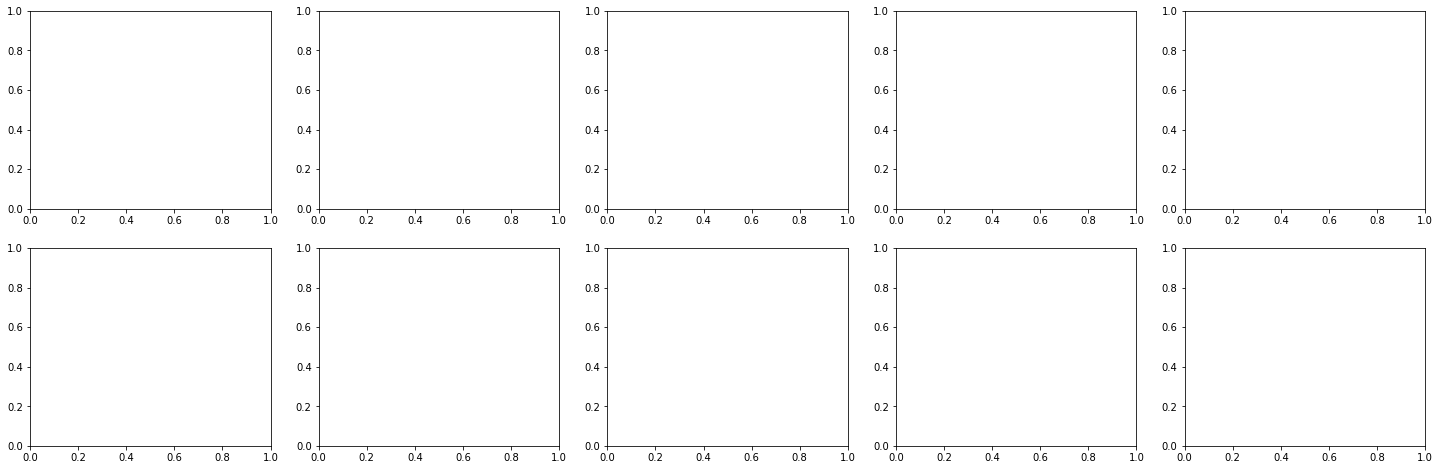

In [11]:
fig, axs = plt.subplots(2,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.reproduced_images[15:25]):
    axs[i].imshow(imgs[:,:,:])

In [ ]:
axs[0].imshow(Dataset.reproduced_images[0,:,:])

In [ ]:
Dataset.reproduced_images.shape

In [ ]:
Dataset.reproduced_images[0]

In [ ]:
Dataset.test_images.shape

In [ ]:
fig, axs = plt.subplots(2,5, figsize=(25,8))
axs = axs.ravel()

for i, imgs in enumerate(Dataset.test_images_[15:25]):
    axs[i].imshow(imgs[:,:,:])